In [381]:
import wrds
import pandas as pd
import matplotlib.pyplot as plt
import csv
import glob
import os
import numpy as np
import matplotlib.dates as mdates
from numpy.linalg import inv

We want to find a such that the annual volatility of $R_{FUND} = R_{T_{Bill}}(1-a) + aR_{DIV}$ is 15%. Hence, since T-bills are considered as risk-free and the DIV annual standard deviation is known from 3c: 

$\sigma(R_{FUND}) = a\sigma(R_{DIV}) = 15\% \implies a = \frac{0,15}{\sigma(R_{DIV})}.$  

Note that we will not short the DIV portfolio as the average return is positive, so the only negative option of a is not taken into account.

In [ ]:
# Q8.1
div_return = pd.read_csv("data/q3/div_return.csv").set_index("date")
div_std = np.sqrt(12)*div_return["DIV_return"].std()
a = 0.15/div_std

print(f"The average value of a is : {a}")


The average value of a is : 1.072346248926775


In [ ]:
# Q8.1
# import MOM, REV, CARRY, DOLLAR, and risk-free
mom_ret_df = pd.read_csv("data/q4/mom_return.csv")
rev_ret_df = pd.read_csv("data/q5/rev_return.csv")
carry_ret_df = pd.read_csv("data/q6/carry_returns.csv")
dollar_ret_df = pd.read_csv("data/q7/USD_vs_World.csv")
risk_free = pd.read_csv('data/preprocess/tbills.csv').set_index("date")

# Merge them in 1 dataframe
returns_df = mom_ret_df.merge(rev_ret_df, on="date", how='inner').merge(carry_ret_df, on="date", how='inner').merge(dollar_ret_df, on="date",how='inner')
returns_df = returns_df.set_index("date")

# Re-create a dataframe with the values of R_fund with DIV only
to_align = div_return.index.intersection(risk_free.index)
div_strategy = div_return.loc[to_align].mul(a).values + risk_free.loc[to_align].mul(1-a).values
df_div_final = pd.DataFrame(div_strategy, columns=["DIV Only"], index=to_align)


In [ ]:
# q8.2
# Adapted risk-free parity calculation method
def risk_parity_s(returns: pd.DataFrame, rf_series: pd.Series):
    # Volatiliy shifted by 1 to match returns on time t with std until t-1 
    rolling_vol = returns.rolling(window=60).std().shift(1).dropna()
    inv_vol = 1 / rolling_vol
    weights = inv_vol.div(inv_vol.sum(axis=1), axis=0).dropna()
    returns_aligned = returns.loc[weights.index]
    return_b = (weights * returns_aligned).sum(axis=1).dropna()
    mean_b = 12*return_b.mean()
    std_b = np.sqrt(12)*return_b.std()
    sharpe_b = (mean_b ) / std_b

    print("RISK-PARITY FOR R_strat : ")
    print(f"Mean return : {mean_b}")
    print(f"Standard deviation : {std_b}")
    print(f"Sharpe ratio : {sharpe_b}")

    return return_b.to_frame().rename(columns={0:"STRAT_return"}), weights

In [385]:
#Q8.c
# Calculate R_strat
ret_strat, weights_strat = risk_parity_strat(returns_df, risk_free["rf"])

RISK-PARITY FOR R_strat : 
Mean return : 0.09984699150896015
Standard deviation : 0.03315597003603447
Sharpe ratio : 3.0114332773387344


In [386]:
#Q8.c
# Adapted mean-variance calculation  method 
def mean_variance(returns: pd.DataFrame):
    rolling_mean = returns.rolling(window=60).mean().dropna()
    rolling_cov = returns.rolling(window=60).cov().dropna()
    
    mv_weights = []
    dates_mv = rolling_mean.index
    columns = returns.columns

    for date in dates_mv:
        mu = rolling_mean.loc[date]
        Sigma = rolling_cov.loc[date]
        w = inv(Sigma) @ mu
        mv_weights.append(w)


    mv_weights_df = pd.DataFrame(mv_weights, index=dates_mv, columns=columns).shift(1)
    returns_aligned_mv = returns.loc[mv_weights_df.index]
    weighted_returns = mv_weights_df * returns_aligned_mv
    return_c = (weighted_returns).sum(axis=1)
    mean_c = 12*return_c.mean()
    std_c = np.sqrt(12)*return_c.std()
    sharpe_c = mean_c / std_c

    print("MEAN-VARIANCE BEFORE NORMALIZING : ")
    print(f"Mean return : {mean_c}")
    print(f"Standard deviation : {std_c}")
    print(f"Sharpe ratio : {sharpe_c} \n")

    new_weights = mv_weights_df.multiply(0.15/std_c)
    new_returns = new_weights*returns_aligned_mv
    return_c = (new_returns).sum(axis=1)
    mean_c = 12*return_c.mean()
    std_c = np.sqrt(12)*return_c.std()
    sharpe_c = mean_c / std_c

    print("MEAN-VARIANCE AFTER NORMALIZING : ")
    print(f"Mean return : {mean_c}")
    print(f"Standard deviation : {std_c}")
    print(f"Sharpe ratio : {sharpe_c} \n")

    return return_c, new_weights


In [387]:
# Q8.c
# Calculate the weights b and c

# Substract the monthly T-bill return to the DIV strategy return to get excess return
rf_df = risk_free
div_rf = div_return
common_index = div_rf.index.intersection(rf_df.index)
div_common = div_rf.loc[common_index]
rf_common = rf_df.loc[common_index]
result = pd.DataFrame(
    div_common.values - rf_common.values,
    index=common_index,
    columns=div_rf.columns
)

# Apply mean-variance and get weights b and c
fund_ret = pd.merge(result, ret_strat, left_index=True, right_index=True)
ret_fund, weights_ret = mean_variance(fund_ret)

print(f"The average value of b is : {weights_ret["DIV_return"].mean()}")
print(f"The average value of c is : {weights_ret["STRAT_return"].mean()}")





MEAN-VARIANCE BEFORE NORMALIZING : 
Mean return : 18.382730148370833
Standard deviation : 4.340476245544782
Sharpe ratio : 4.235187363884209 

MEAN-VARIANCE AFTER NORMALIZING : 
Mean return : 0.6352781045826312
Standard deviation : 0.14999999999999997
Sharpe ratio : 4.235187363884209 

The average value of b is : 0.4117619490603253
The average value of c is : 4.558270891351612


In [ ]:
# Q8.c 
# Calculate the weights of each fund by multiplying c by each weight in STRAT
# T-Bill weight = 1-b

final_weights = weights_strat.mul(weights_ret["STRAT_return"], axis=0).dropna()
final_weights["TBILL"] = 1-weights_ret["DIV_return"]
final_weights["DIV"] = weights_ret["DIV_return"]

weights_strat


,MOM,REV,CARRY,DOLLAR
date,,,,
2012-06-01,0.300193,0.247283,0.190181,0.262344
2012-07-01,0.297025,0.246915,0.192482,0.263578
2012-08-01,0.296852,0.246925,0.193304,0.262919
2012-09-01,0.291670,0.245340,0.197942,0.265048
2012-10-01,0.291767,0.246121,0.196990,0.265122
...,...,...,...,...
2024-08-01,0.213648,0.247133,0.231392,0.307827
2024-09-01,0.214364,0.248841,0.230344,0.306451
2024-10-01,0.214839,0.250501,0.229434,0.305226


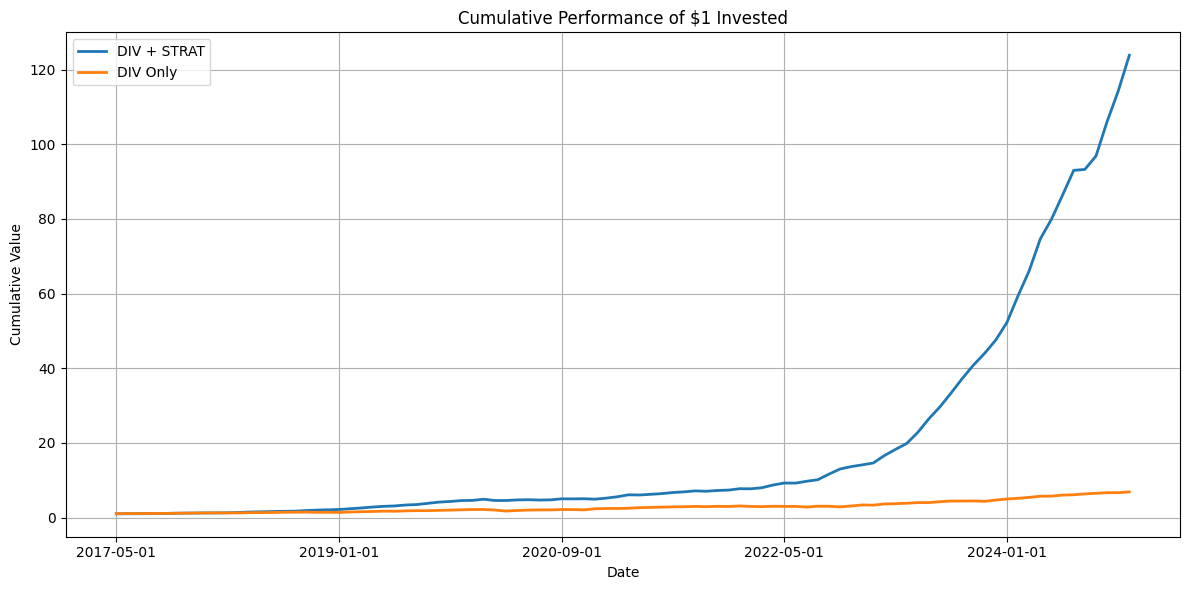

In [389]:
#Q8.d 
# Plot the cumulative performance of both DIV-only and DIV+STRAT fund strategies

df_strat, df_benchmark = ret_fund.align(df_div_final, join='inner')
# Add back the risk-free rate to the second FUND strategy 
df_final_strat =  risk_free.loc[df_strat.index]["rf"] + df_strat
cum_strat = (1 + df_final_strat).cumprod()
cum_benchmark = (1 + df_benchmark).cumprod()
plt.figure(figsize=(12, 6))
cum_strat.plot(ax=plt.gca(), label='DIV + STRAT', linewidth=2)
cum_benchmark.plot(ax=plt.gca(), label='DIV Only', linewidth=2)

plt.title('Cumulative Performance of $1 Invested')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [390]:
#Q8.d 
# Calculate the mean, std and Sharpe ratio of the DIV only strategy
mean = 12*df_div_final["DIV Only"].mean()
std = np.sqrt(12)*df_div_final["DIV Only"].std()
sharpe = (mean-12*risk_free["rf"].mean())/(std)

print("DIV Only : ")
print(f"Mean return : {mean}")
print(f"Standard deviation : {std}")
print(f"Sharpe ratio : {sharpe}")

DIV Only : 
Mean return : 0.1141347626212183
Standard deviation : 0.14995185614597586
Sharpe ratio : 0.6612871341380505


In [ ]:
# Q8.d
# Calculate the mean, std and Sharpe ratio of the DIV+STRAT strategy
mean = 12*df_final_strat.mean()
std = np.sqrt(12)*df_final_strat.std()
sharpe = (mean-12*risk_free["rf"].mean())/(std)

print("DIV + STRAT : ")
print(f"Mean = {mean - 12*risk_free["rf"].mean()}")
print(f"Standard deviation : {std}")
print(f"Sharpe Ratio : {sharpe}")

DIV + STRAT : 
Mean = 0.6562781045826315
Standard deviation : 0.15325494481320326
Sharpe Ratio : 4.184560413058966


In [393]:
df_div_final

,DIV Only
date,
2007-06-01,0.044297
2007-07-01,0.004117
2007-08-01,-0.026027
2007-09-01,0.000957
2007-10-01,0.032070
...,...
2024-08-01,0.037426
2024-09-01,0.027117
2024-10-01,0.024126
